In [29]:
# 모듈 import
import json
import matplotlib.pyplot as plt
import numpy as np
from mmcv import Config
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

In [22]:
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# config file 들고오기
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py')

root='../dataset/'

src_root = root
src_subset = ''
src_file = src_root+'train.json'
src_desc = 'trash_train' # a name (identifier) for the dataset

# dataset config 수정
cfg.data.train.classes = classes
cfg.data.train.img_prefix = root
cfg.data.train.ann_file = root + 'train.json' # train json 정보
cfg.data.train.pipeline[2]['img_scale'] = (512,512) # Resize

cfg.data.test.classes = classes
cfg.data.test.img_prefix = root
cfg.data.test.ann_file = root + 'test.json' # test json 정보
cfg.data.test.pipeline[1]['img_scale'] = (512,512) # Resize

cfg.data.samples_per_gpu = 4

cfg.seed = 2021
cfg.gpu_ids = [0]
cfg.work_dir = './work_dirs/faster_rcnn_r50_fpn_1x_trash'

cfg.model.roi_head.bbox_head.num_classes = 10

cfg.optimizer_config.grad_clip = dict(max_norm=35, norm_type=2)
cfg.checkpoint_config = dict(max_keep_ckpts=3, interval=1)

In [23]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

root.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

# Basic High Level Information

In [25]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]

print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  trash_train
Number of images:  4883
Number of bounding boxes:  23144
Number of classes:  10
Max min avg height:  1024 1024 1024
Max min avg width:  1024 1024 1024


# Class wise distribution of objects¶

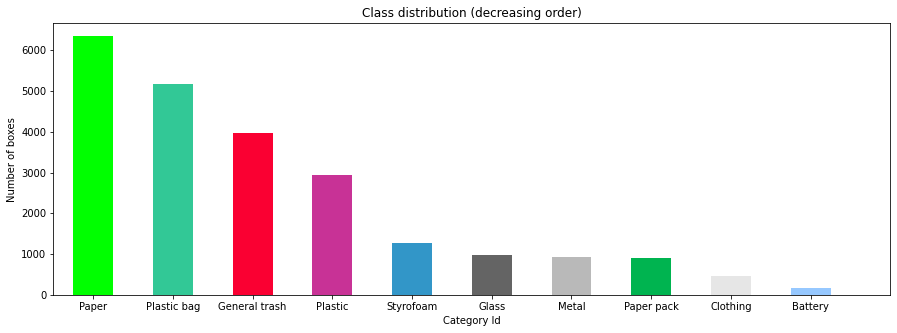

In [56]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]


class_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_color_list = [(250,0,50), (0, 255, 0), (0, 180, 80), (185, 185, 185), (100, 100, 100), (200, 50, 150), (50, 150, 200), (50, 200, 150), (150, 200, 255), (230,230,230)]

class_name_list_by_x = [class_name_list[idx] for idx in x]
color_name_list_by_x = [[clr / 255 for clr in class_color_list[idx]] for idx in x]

plt.figure(figsize=(15,5))
plt.bar(np.arange(len(y)),y, width=0.5, tick_label=class_name_list_by_x, color=color_name_list_by_x)
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()

# build_dataset

In [55]:
# build_dataset
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [65]:
# dataset 확인
datasets[0][0]['img']

DataContainer(tensor([[[-0.7993, -0.7650, -0.5938,  ..., -0.2684, -0.4054, -0.0287],
         [-0.7137, -0.6109, -0.5596,  ..., -0.9020,  0.0227,  0.6221],
         [-0.5596, -0.5424, -0.3712,  ..., -1.0733, -0.6623, -0.0972],
         ...,
         [-0.9877, -0.9363, -0.8164,  ..., -0.4397, -0.7308, -0.1657],
         [-0.9020, -0.9192, -0.9192,  ..., -0.8335, -0.5253, -0.3027],
         [-0.9020, -0.7137, -0.7650,  ..., -1.0904, -0.7137, -0.6281]],

        [[-0.6176, -0.5826, -0.4076,  ..., -0.2150, -0.3725, -0.0224],
         [-0.5301, -0.4251, -0.3725,  ..., -0.8803,  0.0651,  0.6429],
         [-0.3725, -0.3550, -0.1800,  ..., -1.0553, -0.6702, -0.0924],
         ...,
         [-0.8102, -0.7577, -0.6352,  ..., -0.3200, -0.6176, -0.0399],
         [-0.7227, -0.7402, -0.7402,  ..., -0.7227, -0.4076, -0.1800],
         [-0.7227, -0.5301, -0.5826,  ..., -0.9853, -0.6001, -0.5126]],

        [[-0.4101, -0.3753, -0.2010,  ...,  0.0256, -0.2010,  0.0953],
         [-0.3230, -0.2184, -0.

In [ ]:
# 데이터셋 불러오기
annotation = '../dataset/train.json' # annotation 경로
data_dir = '../dataset' # data_dir 경로
train_dataset = CustomDataset(annotation, data_dir, get_train_transform()) 

class_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_color_list = [(250,0,50), (0, 255, 0), (0, 180, 80), (185, 185, 185), (100, 100, 100), (200, 50, 150), (50, 150, 200), (50, 200, 150), (200, 200, 200), (255,255,255)]

import random

# 데이터셋 확인하기
plt.figure(figsize=(16,16))
for i in range(16):
    ran_num = random.randrange(1, 4884)
    
    im = train_dataset[ran_num][0].permute(1, 2, 0).numpy()
    im = (im * 255).astype(np.uint8)

    for j in range(len(train_dataset[ran_num][1]['labels'])):

        label_idx = train_dataset[ran_num][1]['labels'][j]-1
        box = list(map(int, train_dataset[ran_num][1]['boxes'][j]))
        cv2.rectangle(im, (box[0], box[1]), (box[2], box[3]), class_color_list[label_idx], 5)

        text = class_name_list[label_idx]    
        cv2.rectangle(im, (box[0], box[1] - 50), (box[0] + 300, box[1]), class_color_list[label_idx], -1)
        cv2.putText(im, text, (box[0], box[1] - 10), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 5, cv2.LINE_AA)

    plt.subplot(4, 4, i+1)
    # plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(im)

# 모델 build 및 pretrained network 불러오기

In [12]:
# 모델 build 및 pretrained network 불러오기
model = build_detector(cfg.model)
model.init_weights()

/opt/ml/detection/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '
2021-09-29 11:53:07,342 - mmcv - INFO - initialize ResNet with init_cfg {'type': 'Pretrained', 'checkpoint': 'open-mmlab://detectron2/resnet50_caffe'}
2021-09-29 11:53:07,343 - mmcv - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
2021-09-29 11:53:07,344 - mmcv - INFO - Use load_from_openmmlab loader
Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_msra-5891d200.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet50_msra-5891d200.pth


  0%|          | 0.00/89.9M [00:00<?, ?B/s]

2021-09-29 11:53:18,747 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias

2021-09-29 11:53:18,795 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2021-09-29 11:53:18,821 - mmcv - INFO - initialize RPNHead with init_cfg {'type': 'Normal', 'layer': 'Conv2d', 'std': 0.01}
2021-09-29 11:53:18,829 - mmcv - INFO - initialize Shared2FCBBoxHead with init_cfg [{'type': 'Normal', 'std': 0.01, 'override': {'name': 'fc_cls'}}, {'type': 'Normal', 'std': 0.001, 'override': {'name': 'fc_reg'}}, {'type': 'Xavier', 'layer': 'Linear', 'override': [{'name': 'shared_fcs'}, {'name': 'cls_fcs'}, {'name': 'reg_fcs'}]}]
2021-09-29 11:53:19,136 - mmcv - INFO - 
backbone.conv1.weight - torch.Size([64, 3, 7, 7]): 
PretrainedInit: load from open-mmlab://detectron2/resnet50_caffe 
 
2021-09-29 11:53:19,137 - mmcv - INFO - 
backbone.bn1.weight - torch.Size([64]): 
PretrainedInit: loa

# 모델 학습

In [6]:
# 모델 학습
train_detector(model, datasets[0], cfg, distributed=False, validate=False)

2021-09-29 07:57:41,743 - mmdet - INFO - Start running, host: root@1a2189fbf54f, work_dir: /opt/ml/detection/mmdetection/work_dirs/faster_rcnn_r50_fpn_1x_trash
2021-09-29 07:57:41,744 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
 -------------------- 
after_train_iter:
(ABOVE_NORMAL) OptimizerHook                      
(NORMAL      ) CheckpointHook                     
(LOW         ) IterTimerHook                      
(V